In [1]:
import numpy as np
import pandas as pd
import math
from random import sample
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification' 
data_dir = 'data'
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_spoon = df_train_full.query('label == "spoon"').copy()
df_spoon.reset_index(drop=True, inplace = True)
df_spoon

,Id,label,filename
0,4436,spoon,data/images/4436.jpg
1,8987,spoon,data/images/8987.jpg
2,7143,spoon,data/images/7143.jpg
3,5511,spoon,data/images/5511.jpg
4,6333,spoon,data/images/6333.jpg
...,...,...,...
1507,eu.8d35c3fa-7f92-4c95-a1a4-93c5cc310d74,spoon,data/images/eu.8d35c3fa-7f92-4c95-a1a4-93c5cc3...
1508,eu.85b94ad2-42ee-4a51-9373-0d684eb1d6ce,spoon,data/images/eu.85b94ad2-42ee-4a51-9373-0d684eb...
1509,eu.0b5ee249-6403-4760-b886-05f6eef24e82,spoon,data/images/eu.0b5ee249-6403-4760-b886-05f6eef...
1510,eu.00c1e908-a79b-43d9-b11b-d51e4eb1061e,spoon,data/images/eu.00c1e908-a79b-43d9-b11b-d51e4eb...


In [7]:
spoons = []
for filename in df_spoon.filename:
    image = io.imread(filename)
    spoons.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
train_aug1 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        #iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.8, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug1"
)

In [10]:
train_aug2 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        #iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.8, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug2"
)

In [11]:
spoons_aug = train_aug(images = sample(spoons, 190))
#spoons_aug += train_aug1(images = spoons)
#spoons_aug += train_aug2(images = sample(spoons, 690))

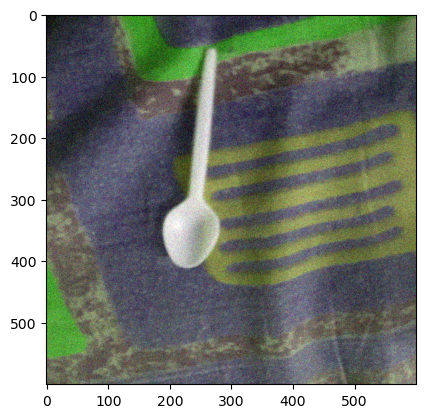

In [12]:
image = spoons_aug[70]
plt.imshow(image)

In [13]:
np.asarray(spoons_aug).shape

(190, 600, 600, 3)

In [14]:
len(spoons_aug)

190

In [15]:
df_spoon_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(spoons_aug)):
    file_name = 'spoon_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', spoons_aug[i])
    df_spoon_aug.loc[len(df_spoon_aug)] = ['spoon_aug_'+str(i), 'spoon']
    
df_spoon_aug

,Id,label
0,spoon_aug_0,spoon
1,spoon_aug_1,spoon
2,spoon_aug_2,spoon
3,spoon_aug_3,spoon
4,spoon_aug_4,spoon
...,...,...
185,spoon_aug_185,spoon
186,spoon_aug_186,spoon
187,spoon_aug_187,spoon
188,spoon_aug_188,spoon


In [16]:
df_spoon_aug.to_csv(data_dir+'/spoon_aug.csv', index = False)

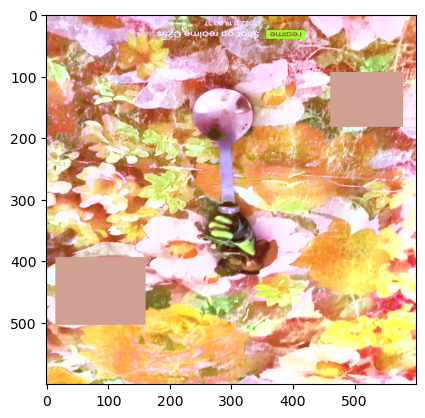

In [17]:
image = spoons_aug[64]
plt.imshow(image)